# Validator

This file runs the validation used. It contains copies of the core functions of the app, with some additional functions to quickly get validation results. There is also some visualization code at the end to produce graphs for the presentation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def bounds_from_risk_tol(risk_tol):
    if(risk_tol==1):
        return([.20, .35, .55, .65])
    elif(risk_tol==2):
        return([.30, .45, .45, .55])
    elif(risk_tol==3):
        return([.40, .55, .35, .45])
    elif(risk_tol==4):
        return([.50, .65, .25, .35])
    elif(risk_tol==5):
        return([.60, .75, .15, .25])

def port_tsdf(portfolio, opt_portfolio, returnsDF, startQuarter, endQuarter):
    returns_small = returnsDF[(returnsDF['Quarter']>=startQuarter) & (returnsDF['Quarter']<=endQuarter)].copy()
    returns_small['Current Portfolio'] = returns_small['Equities']*portfolio['stock weight'].values+returns_small['Bonds']*portfolio['bond weight'].values
    returns_small['Optimal Portfolio'] = returns_small['Equities']*opt_portfolio['stock weight'].values+returns_small['Bonds']*opt_portfolio['bond weight'].values+returns_small['Real Estate']*opt_portfolio['real estate weight'].values
    return(returns_small[['Quarter', 'Current Portfolio', 'Optimal Portfolio']])

def draw_perform(port_ts_df):
#    port_ts_df['Current Portfolio Cumulative'] = port_ts_df['Current Portfolio'].cumprod()
#    port_ts_df['Optimal Portfolio Cumulative'] = port_ts_df['Optimal Portfolio'].cumprod()

    #g = sns.lineplot(x='Quarter', y='value', hue='variable', data=pd.melt(port_ts_df, id_vars=['Quarter'], value_vars = ['Equities', 'Bonds', 'Real Estate', 'Portfolio']))
    g= sns.lineplot(x='Quarter', y='value', hue='variable', data=pd.melt(port_ts_df, id_vars=['Quarter'], value_vars=['Current Portfolio', 'Optimal Portfolio']))
    plt.setp(g.get_xticklabels(), rotation=45, visible=True, ha='right')
    return g

def get_optimal_portfolio(risk_tolerance):
    #read datasets
    vp = pd.read_csv('/home/jpreszler/github/insight-project/data/vp-sharpe-all.csv')
    #curr_sw = current_portfolio['stock weight']
    #curr_bw = current_portfolio['bond weight']
    #similar_port = vp[(np.abs(vp['stock weight']-curr_sw)<.02) & (np.abs(vp['bond weight']-curr_bw) < .02)]
    bds = bounds_from_risk_tol(risk_tolerance)
    vp_red = vp[((vp['stock weight']<bds[1])& (vp['stock weight']>bds[0])& (vp['bond weight']<bds[3]) & (vp['bond weight']>bds[2]))]
    #bigger_sharpe = vp[vp['Sharpe']<similar_port['Sharpe'].mean()]
    #less_varied_sharpe = vp[vp['std Sharpe']<similar_port['std Sharpe'].mean()]
    opt = vp_red[vp_red['Sharpe']==vp_red['Sharpe'].max()]
    #opt_range = vp_red[((vp['mean Sharpe'].max()-vp['mean Sharpe'])<.01)]
    opt_df = pd.DataFrame({'name': 'Optimal', 'stock weight': opt['stock weight'].max(), 'bond weight': opt['bond weight'].max(), 'real estate weight': opt['real estate weight'].min()}, index=[0])
    #for testing only
#    ret = np.random.choice(range(0, len(both)), 1)[0]
    return(opt_df)


In [17]:
def validator(csw, cbw, rt):
    ret_df = pd.read_csv('/home/jpreszler/github/insight-project/wk3_app/static/asset-returns-full-quarterly-risk-free.csv')
    current_portfolio = pd.DataFrame({'name':'Current', 'stock weight':csw, 'bond weight': cbw, 'real estate weight':0}, index=[0])

    #optimal_portfolio = get_optimal_portfolio(current_portfolio, risk_tolerance)
    opt_portfolio = get_optimal_portfolio(rt)
    #portfolio_comparison_df = compare_portfolios(current_portfolio, optimal_portfolio)
    port_returns = port_tsdf(current_portfolio, opt_portfolio, ret_df, '2014Q1', '2019Q1')
    opt_ahead = port_returns[port_returns['Optimal Portfolio']>=port_returns['Current Portfolio']]['Quarter'].count()
    mean_diff = np.round((port_returns['Optimal Portfolio']-port_returns['Current Portfolio']).mean(), decimals=3)
    std_diff = (np.round((port_returns['Optimal Portfolio'].std()-port_returns['Current Portfolio'].std()), decimals=3))
    tr_diff = (np.round((((1+port_returns['Optimal Portfolio']/100).prod()-(1+port_returns['Current Portfolio']/100).prod())*100), decimals=3))
    tr_opt = (np.round((((1+port_returns['Optimal Portfolio']/100).prod()-1)*100), decimals=3))
    tr_curr = (np.round((((1+port_returns['Current Portfolio']/100).prod()-1)*100), decimals=3))
    
    return([mean_diff, tr_diff, tr_opt, tr_curr, std_diff, opt_ahead, rt])

def validator_graph(csw, cbw, rt):
    ret_df = pd.read_csv('/home/jpreszler/github/insight-project/wk3_app/static/asset-returns-quarterly.csv')
    current_portfolio = pd.DataFrame({'name':'Current', 'stock weight':csw, 'bond weight': cbw, 'real estate weight':0}, index=[0])

    #optimal_portfolio = get_optimal_portfolio(current_portfolio, risk_tolerance)
    opt_portfolio = get_optimal_portfolio(rt)
    #portfolio_comparison_df = compare_portfolios(current_portfolio, optimal_portfolio)
    port_returns = port_tsdf(current_portfolio, opt_portfolio, ret_df, '2014Q1', '2019Q1')
    g = draw_perform(port_returns)
    return(g)


In [18]:
validator(.6, .4, 3)

[0.001, 0.799, 46.598, 45.799, -0.991, 8, 3]

In [19]:
test = pd.read_csv('validation_data.csv')
test.shape

(25, 3)

In [20]:
col =['row','mean diff', 'tr diff', 'RealAllocator', 'Current', 'risk diff', 'ahead', 'Risk Tolerance']
results = pd.DataFrame(columns=col)
for k, r in test.iterrows():
    res0,res1,res2, res3, res4, res5, res6=validator(r['sw'],r['bw'],r['rt'])
    results=results.append(pd.Series([k, res0,res1,res2, res3, res4, res5, res6], index=col), ignore_index=True)

In [21]:
results.head()

,row,mean diff,tr diff,RealAllocator,Current,risk diff,ahead,Risk Tolerance
0,0.0,0.109,3.284,34.465,31.181,-0.650,10.0,1.0
1,1.0,0.217,6.104,34.465,28.361,-0.463,14.0,1.0
2,2.0,0.325,8.888,34.465,25.577,-0.310,18.0,1.0
3,3.0,0.261,7.222,34.465,27.243,-0.397,17.0,1.0
4,4.0,0.174,4.980,34.465,29.485,-0.535,12.0,1.0


In [39]:
results[results['tr diff']<0]

,row,mean diff,tr diff,risk diff,ahead
24,24.0,-0.215,-5.085,-1.573,8.0


In [12]:
results.describe()

,row,mean diff,tr diff,tr_opt,tr_curr,risk diff,ahead
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,12.000000,0.180840,5.709280,46.759000,41.049400,-0.553600,13.360000
std,7.359801,0.114865,3.103193,8.979163,10.141942,0.280847,3.377376
min,0.000000,-0.215000,-5.085000,34.465000,25.577000,-1.573000,8.000000
25%,6.000000,0.113000,4.352000,40.457000,32.890000,-0.650000,10.000000
50%,12.000000,0.217000,6.159000,46.598000,40.439000,-0.481000,14.000000
75%,18.000000,0.261000,7.438000,52.959000,47.609000,-0.397000,17.000000
max,24.000000,0.329000,10.151000,59.316000,64.400000,-0.150000,19.000000


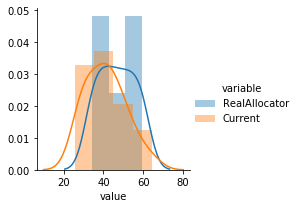

In [22]:
res_long = pd.melt(results, id_vars = ['row', 'Risk Tolerance'], value_vars = ['RealAllocator', 'Current'])
g = sns.FacetGrid(data=res_long, hue='variable')
g.map(sns.distplot, 'value')
g.add_legend()

Text(0.5, 0, 'Gain in Total Returns')

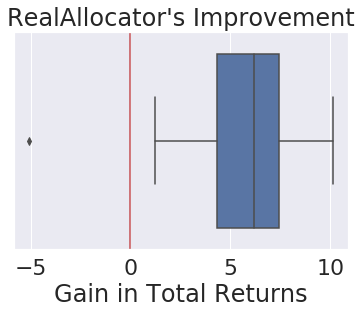

In [46]:
sns.set(font_scale=2)
sns.boxplot(x='tr diff', data=results)
plt.axvline(c='r')
plt.title("RealAllocator's Improvement")
plt.xlabel('Gain in Total Returns')

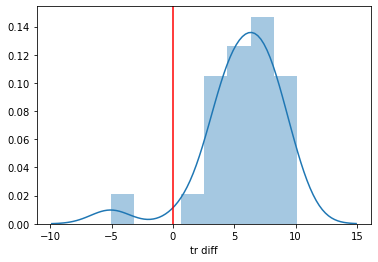

In [43]:
p = sns.distplot(results['tr diff'])
p.axvline(c='r')
plt.show()

In [46]:
opt = get_optimal_portfolio(3)
opt.head()

,name,stock weight,bond weight,real estate weight
0,Optimal,0.41,0.36,0.23


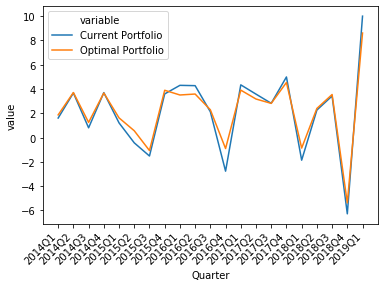

In [63]:
g = validator_graph(.6, .4, 4)
plt.show()

In [27]:
vp = pd.read_csv('data/vp-sharpe-all.csv')
vp.head()

,stock weight,bond weight,real estate weight,Sharpe All,Sharpe 0,Sharpe 1,Sharpe 2,Sharpe,std Sharpe
0,0.0,0.00,1.00,1.911,1.478,0.903,1.874,1.42,0.4
1,0.0,0.01,0.99,1.892,1.473,0.909,1.880,1.42,0.4
2,0.0,0.02,0.98,1.865,1.467,0.907,1.881,1.42,0.4
3,0.0,0.03,0.97,1.831,1.459,0.901,1.877,1.41,0.4
4,0.0,0.04,0.96,1.793,1.449,0.895,1.869,1.40,0.4


In [87]:
vp_sample = vp[((vp['stock weight']<.85) & (vp['bond weight']<.45) & (vp['real estate weight']<.25))].copy()
vp_sample['valid'] = np.where(((vp_sample['stock weight']>.50) & (vp_sample['bond weight']>.10)), 'yes','no')


In [88]:
vp['valid'].value_counts()

no     4696
yes     105
Name: valid, dtype: int64

      stock weight  bond weight  real estate weight  Sharpe All  Sharpe 0  \
4044          0.61         0.15                0.24       0.392     0.023   
4080          0.62         0.14                0.24       0.392     0.021   
4116          0.63         0.13                0.24       0.392     0.020   
4152          0.64         0.12                0.24       0.392     0.019   
4188          0.65         0.11                0.24       0.392     0.017   

      Sharpe 1  Sharpe 2  Sharpe  std Sharpe valid  
4044    -0.438     2.201     0.6        1.15   yes  
4080    -0.443     2.211     0.6        1.16   yes  
4116    -0.448     2.220     0.6        1.16   yes  
4152    -0.453     2.228     0.6        1.17   yes  
4188    -0.458     2.235     0.6        1.17   yes  


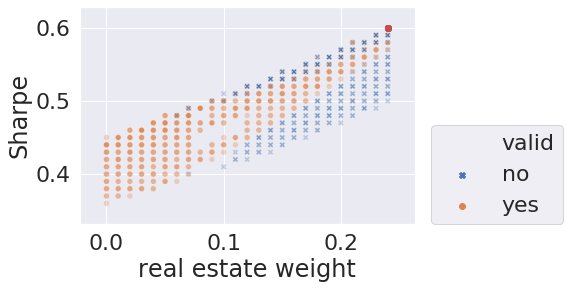

In [92]:
opt = vp_sample[((vp_sample['valid']=='yes'))].copy()
opt = opt[opt['Sharpe']==opt['Sharpe'].max()]
print(opt)
sns.scatterplot(x='real estate weight', y='Sharpe', hue='valid', hue_order=['no', 'yes'], style='valid', style_order=['yes', 'no'], alpha=.3, data=vp_sample)
plt.scatter(x=opt['real estate weight'], y=opt['Sharpe'], c='r')
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0.)